In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import random
import os

2022-07-04 21:38:19.926027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

## Fine-Tune U-Net Trained on Source Domain

In [4]:
from models import encoder, unet

s_encoder = encoder.get_model()
u_net = unet.get_model()
t_model = keras.models.Model(
    inputs=s_encoder.inputs,
    outputs=u_net(s_encoder(s_encoder.inputs))
)
t_model.load_weights('s_model.h5')

## Load MAI2021 ISP Dataset
- https://github.com/MediaTek-NeuroPilot/mai21-learned-smartphone-isp

In [5]:
base_dir = "/home/gosha20777/MAI2021"
train_input_dir = os.path.join(base_dir, "mediatek_raw")
train_target_dir = os.path.join(base_dir, "fujifilm")
img_size = (128, 128)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))

Number of samples: 24161
0.png | 0.png
1.png | 1.png
10.png | 10.png
100.png | 100.png
1000.png | 1000.png
10000.png | 10000.png
10001.png | 10001.png
10002.png | 10002.png
10003.png | 10003.png
10004.png | 10004.png


In [6]:
from datasets.mai import MaiLoader

val_samples = 20000
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = MaiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
val_gen = MaiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)

print("Number train samples:", len(train_input_img_paths))
print("Number val samples:", len(val_input_img_paths))

Number train samples: 4161
Number val samples: 20000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


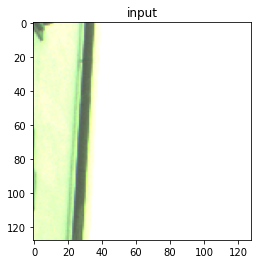

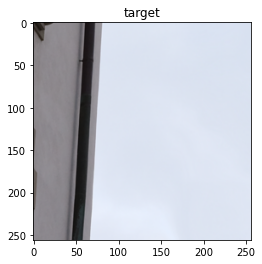

In [7]:
x, y = train_gen.__getitem__(0)
plt_display(x[3][:,:,0:3], 'input')
plt_display(y[3], 'target')

## Eval Without Training

In [8]:
from losses.losses import mssim, vgg_loss

def main_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred) + \
        mssim(y_true, y_pred) + \
        vgg_loss(y_true, y_pred)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

In [9]:
t_model.compile(optimizer="adam", loss=main_loss, metrics=[psnr, ssim])

print("Evaluate on val data")
_, psnr_val, ssim_val = t_model.evaluate(val_gen)
print(f"psnr: {psnr_val}, ssim: {ssim_val}")

Evaluate on val data


2022-07-04 21:39:11.931268: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-04 21:39:11.948021: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3792765000 Hz
2022-07-04 21:39:12.637661: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-04 21:39:13.103230: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-07-04 21:39:13.116321: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-07-04 21:39:13.429121: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


2500/2500 [==============================] - 149s 57ms/step - loss: 2.3278 - psnr: 5.9892 - ssim: 0.4809
psnr: 5.996619701385498, ssim: 0.4811781644821167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


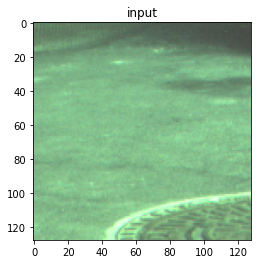

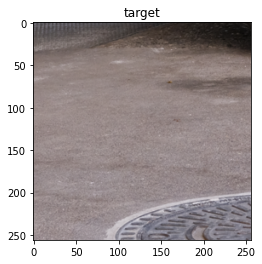

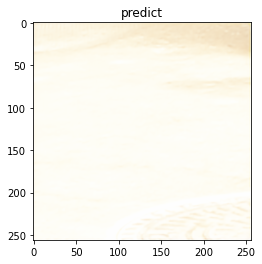

In [10]:
x, y = val_gen.__getitem__(1)
preds = t_model.predict(x)
plt_display(x[0][:,:,0:3], 'input')
plt_display(y[0], 'target')
plt_display(preds[0], 'predict')

## Fine-Tune Model

In [11]:
epochs = 4

callbacks = [
    keras.callbacks.ModelCheckpoint("t_model_tuned.h5", save_best_only=True)
]


t_model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, workers=8)

Epoch 1/4
520/520 [==============================] - 220s 406ms/step - loss: 0.6046 - psnr: 22.1237 - ssim: 0.8313 - val_loss: 0.5542 - val_psnr: 22.6179 - val_ssim: 0.8392
Epoch 2/4
520/520 [==============================] - 213s 409ms/step - loss: 0.5418 - psnr: 22.7107 - ssim: 0.8463 - val_loss: 0.5492 - val_psnr: 22.3496 - val_ssim: 0.8451
Epoch 3/4
520/520 [==============================] - 213s 409ms/step - loss: 0.5283 - psnr: 22.8455 - ssim: 0.8492 - val_loss: 0.5276 - val_psnr: 23.0069 - val_ssim: 0.8508
Epoch 4/4
520/520 [==============================] - 213s 409ms/step - loss: 0.5208 - psnr: 22.9042 - ssim: 0.8517 - val_loss: 0.5258 - val_psnr: 22.7557 - val_ssim: 0.8485


### Evaluate

In [12]:
print("Evaluate on val data")
_, psnr_val, ssim_val = t_model.evaluate(val_gen)
print(f"psnr: {psnr_val}, ssim: {ssim_val}")

Evaluate on val data
2500/2500 [==============================] - 146s 58ms/step - loss: 0.5258 - psnr: 22.7557 - ssim: 0.8485
psnr: 22.75571632385254, ssim: 0.8485182523727417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


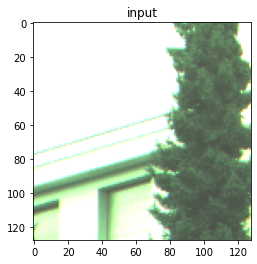

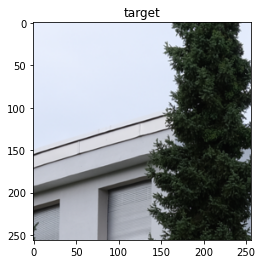

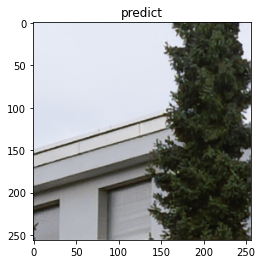

In [14]:
x, y = val_gen.__getitem__(0)
preds = t_model.predict(x)
plt_display(x[0][:,:,0:3], 'input')
plt_display(y[0], 'target')
plt_display(preds[0], 'predict')